In [1]:
from emulator_utils.pre_process import load_scaler
from emulator_utils.split import random_holdout
from emulator_utils.surrogates import load_mlp, mcdrop_pred

In [2]:
import matplotlib.pylab as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [3]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.313, Ob0=0.049)
Lsol = 3.846*1E33 # ergs per second

## Loading the trained models -- pre-processing and the network

In [4]:
scaler = load_scaler('../test/model/input_scale')
scaler_y = load_scaler('../test/model/output_scale')
mlp = load_mlp('../test/model/spec_mlp')

Loading the pre-processing pipeline from: ../test/model/input_scale.pkl
Loading the pre-processing pipeline from: ../test/model/output_scale.pkl
Model loaded from: ../test/model/spec_mlp


In [5]:
# dirIn = '../test/data/sps_ugrizy/'
dirIn = '/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/TrainingData/Data/'

mags = np.load(dirIn + 'spec.npy')

ebv = np.load(dirIn + 'ebv.npy')
redshift = np.load(dirIn + 'redshift.npy')
sfh = np.load(dirIn + 'sfh.npy')
wave = np.load(dirIn + 'wave_spec.npy')

sps_inputs = np.concatenate((redshift[np.newaxis, :], ebv[np.newaxis, :], sfh.T), axis=0).T

_, param_test_unscaled, _, mag_test_unscaled = random_holdout(sps_inputs, mags, split_fraction = 0.1)

# Calling the spectral surrogate

In [6]:
pcolor_all, _, _ = mcdrop_pred(param_test_unscaled, mlp, scaler, scaler_y)

## Plotting

(0.001, 20000000.0)

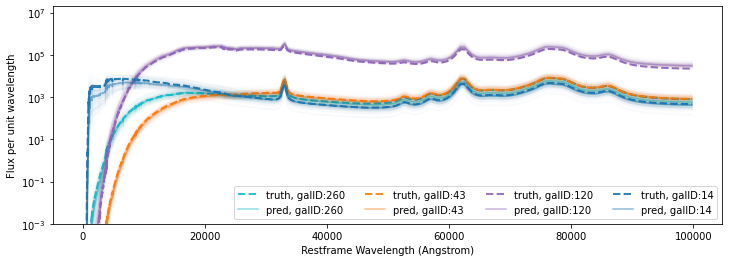

In [7]:
plt.figure(figsize = (12, 4))

galID_arr =  [260, 43, 120, 14]
colorparams = galID_arr
colormap = cm.tab10
normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))


for galID in galID_arr:

    color = colormap(normalize(galID))
    
    plt.plot(wave, mag_test_unscaled[galID], linestyle='dashed', color = color, label='truth, galID:%d'%galID, alpha=0.9, linewidth = 2)
    
    plt.plot(wave, pcolor_all[:, galID, :].T,  color = color, alpha=0.01)
    plt.plot(wave, np.median(pcolor_all[:, galID, :].T, axis=1),  color = color, alpha=0.5, label='pred, galID:%d'%galID);


plt.ylabel('Flux per unit wavelength')
plt.xlabel(' Restframe Wavelength (Angstrom) ')

plt.yscale('log')
# plt.xscale('log')
plt.legend(ncol=4)
plt.ylim(1e-3, 2e7)

# plt.savefig('spec_surrogate_validation.png')

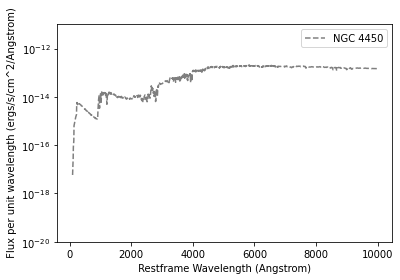

In [8]:



dir0 = '/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/phoZ/PhoZ_fromDesktop/SynData/fromRoomba/synVUDS/An_Atlas_of_Galaxy_SEDs/An_Atlas_of_Galaxy_SEDs/'
fil0 = 'NGC_4450_spec.dat'
fil1 = 'NGC_0855_spec.dat'

ngc_4450 = np.loadtxt(dir0 + fil0, skiprows = 9)
ngc_0855 = np.loadtxt(dir0 + fil1, skiprows = 9)

plt.plot( ngc_4450[:, 0][ngc_4450[:, 0] < 1E4], ngc_4450[:, 1][ngc_4450[:, 0] < 1E4], 'black' , ls = '--', alpha = 0.5, label = 'NGC 4450')
plt.ylabel(' Flux per unit wavelength (ergs/s/cm^2/Angstrom)')
plt.xlabel(' Restframe Wavelength (Angstrom) ')
plt.yscale('log')
plt.ylim(1e-20, 1e-11)
plt.legend()
plt.show()

In [9]:
redshift_in = 0.3
ebv_in = 1.0
sfh_in = sfh[0]

sps_inputs = np.concatenate(([redshift_in, ebv_in], sfh_in.T), axis=0)[np.newaxis, :]

In [10]:
zz1 = np.array([redshift_in]) # this is only true for nn_zz = 1    http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NGC+4450
dd1 = cosmo.luminosity_distance(zz1).to(u.cm)

spec_pred, _, _ = mcdrop_pred(sps_inputs, mlp, scaler, scaler_y)
spec_pred_mean = np.median(spec_pred[:, 0, :], axis=0)

In [11]:
########################################################
########################################################

def spec_opt(input_params):
    
    # redshift, dust2val, sfh_id = input_params

    '''
    sp1 = fsps.StellarPopulation(**mock_params)

    sfh1 = sfh[np.rint(sfh_id).astype('int'), :][np.newaxis, :]
    sp1.set_tabular_sfh(tt, sfh1[0], Z = meth1[0])

    sp1.params['dust2'] = dust2val
    # sp1.params['zmet'] = np.rint(zmet_val).astype('int')
    # print(sp1.params)
    fsps_wave0, fsps_spec0 = sp1.get_spectrum(tage= zz_age1 , peraa = True)
    '''
    
    

    # wave1 = (fsps_wave0[fsps_wave0 < 1E4][0:200])#.tolist()
    wave1 = wave[0:500]#.tolist()
    wave2 = (ngc_4450[:, 0][ngc_4450[:, 0] < 1E4])

    ###################
    
    zz1 = np.array([redshift_in]) # this is only true for nn_zz = 1    http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NGC+4450
    dd1 = cosmo.luminosity_distance(zz1).to(u.cm)

    spec_pred, _, _ = mcdrop_pred(input_params, mlp, scaler, scaler_y)
    spec_pred_mean = np.median(spec_pred[:, 0, :], axis=0)
    
    
    spec1 = (spec_pred_mean*Lsol/(4*np.pi*dd1**2))[0:500]
    spec2 = (ngc_4450[:, 1][ngc_4450[:, 0] < 1E4])
    ####################

    # spec1 = (fsps_spec0[fsps_wave0 < 1E4]*Lsol/(4*np.pi*dd1**2))[0:200]
    # spec2 = (ngc_4450[:, 1][ngc_4450[:, 0] < 1E4])
    

    closest_spec2 = np.zeros_like(wave1)

    for i in range(len(wave1)):

        temp_result = abs(wave1[i] - wave2) #Matrix subtraction
        
        min_val = np.amin(temp_result) #Getting the minimum value to get closest element
        min_val_index = np.where(temp_result == min_val) #To find index of minimum value

        closest_element = wave2[min_val_index] #Actual value of closest element in list2
        closest_spec2[i] = spec2[min_val_index]

        # print(i, wave1[i], min_val_index[0][0], closest_element[0], closest_spec2[i])

    log_spec_diff = np.mean( (np.log10(spec1.value) - np.log10(closest_spec2) )**2 )

    print('log spec diff: %.1f \t dust_ebv: %.4f \t redshift: %.4f \t '%(log_spec_diff, input_params[:, 0], input_params[:, 1] ) )
    # print('SFH: '+ str(input_params[:, 2:]))
    
    return log_spec_diff

########################################################
########################################################


In [12]:
import scipy.optimize as optimize


redshift_in = 1.0
ebv_in = 0.2
# 260, 43, 120, 14
sfh_in = sfh[0]

init_params = np.concatenate(([redshift_in, ebv_in], sfh_in.T), axis=0)[np.newaxis, :]
spec_init, _, _ = mcdrop_pred(init_params, mlp, scaler, scaler_y)


spec_opt(init_params)

log spec diff: 504.1 	 dust_ebv: 1.0000 	 redshift: 0.2000 	 


504.13278764952554

In [13]:
def spec_opt2(input_params2):
    sfh_in = sfh[0]
    input_params = np.concatenate((input_params2, sfh_in.T), axis=0)[np.newaxis, :]
    log_spec_diff = spec_opt(input_params)
    
    return log_spec_diff
  
spec_opt2([redshift_in, ebv_in])

log spec diff: 506.9 	 dust_ebv: 1.0000 	 redshift: 0.2000 	 


506.92545151795696

In [14]:
# bounds = ((0.0, 2.0), (0.0, 5.0),)
bounds = ((0.0, 0.4), (0.5, 1.5),)

init_params2 = np.array([redshift_in, ebv_in])
opt_params_all = optimize.minimize(spec_opt2, init_params2, method='L-BFGS-B', bounds = bounds, tol = 1e-7)
# opt_params_all = optimize.minimize(spec_opt, init_params, method='L-BFGS-B', tol = 1e2)

# print(opt_params_all.x)
opt_params2 = opt_params_all.x
print(opt_params2)

log spec diff: 666.1 	 dust_ebv: 0.4000 	 redshift: 0.5000 	 
log spec diff: 666.1 	 dust_ebv: 0.4000 	 redshift: 0.5000 	 
log spec diff: 666.6 	 dust_ebv: 0.4000 	 redshift: 0.5000 	 
log spec diff: 672.1 	 dust_ebv: 0.0000 	 redshift: 0.5000 	 
log spec diff: 668.1 	 dust_ebv: 0.0000 	 redshift: 0.5000 	 
log spec diff: 667.0 	 dust_ebv: 0.0000 	 redshift: 0.5000 	 
log spec diff: 663.9 	 dust_ebv: 0.1668 	 redshift: 0.5000 	 
log spec diff: 661.5 	 dust_ebv: 0.1668 	 redshift: 0.5000 	 
log spec diff: 663.9 	 dust_ebv: 0.1668 	 redshift: 0.5000 	 
log spec diff: 661.1 	 dust_ebv: 0.2642 	 redshift: 0.5000 	 
log spec diff: 660.8 	 dust_ebv: 0.2642 	 redshift: 0.5000 	 
log spec diff: 661.2 	 dust_ebv: 0.2642 	 redshift: 0.5000 	 
log spec diff: 664.0 	 dust_ebv: 0.3218 	 redshift: 0.5000 	 
log spec diff: 663.7 	 dust_ebv: 0.3218 	 redshift: 0.5000 	 
log spec diff: 660.2 	 dust_ebv: 0.3218 	 redshift: 0.5000 	 
log spec diff: 663.3 	 dust_ebv: 0.3548 	 redshift: 0.5000 	 
log spec

In [15]:
init_params2.shape, opt_params2.shape

((2,), (2,))

In [16]:
# (0.0, 2.0), (0.0, 5.0), 178*((1e-3, 1e3), )

In [17]:
init_params = np.concatenate((init_params2, sfh_in.T), axis=0)[np.newaxis, :]
spec_init, _, _ = mcdrop_pred(init_params, mlp, scaler, scaler_y)

zz1 = np.array([init_params2[0]]) # this is only true for nn_zz = 1    http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NGC+4450
dd1 = cosmo.luminosity_distance(zz1).to(u.cm)

spec_init_median = np.median(spec_init, axis=0)[0]*Lsol/(4*np.pi*dd1**2)

opt_params180 = np.concatenate((opt_params2, sfh_in.T), axis=0)[np.newaxis, :]
spec_opti, _, _ = mcdrop_pred(opt_params180, mlp, scaler, scaler_y)

zz1 = np.array([opt_params2[0]]) # this is only true for nn_zz = 1    http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NGC+4450
dd1 = cosmo.luminosity_distance(zz1).to(u.cm)

spec_opti_median = np.median(spec_opti, axis=0)[0]*Lsol/(4*np.pi*dd1**2)

(1e-30, 1e-11)

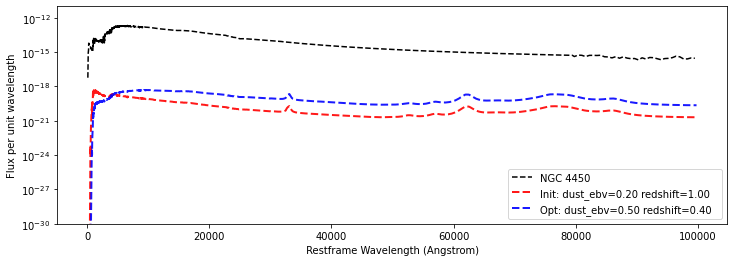

In [18]:
plt.figure(figsize = (12, 4))

colormap = cm.tab10
normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

plt.plot(ngc_4450[:, 0][ngc_4450[:, 0] < 1E5], ngc_4450[:, 1][ngc_4450[:, 0] < 1E5], 'black' , ls = '--', alpha = 1, label = 'NGC 4450')
plt.plot(wave, spec_init_median, linestyle='dashed', color = 'red', label='Init: dust_ebv=%.2f redshift=%.2f  '%(init_params2[1], init_params2[0]), alpha=0.9, linewidth = 2)
plt.plot(wave, spec_opti_median, linestyle='dashed', color = 'blue', label='Opt: dust_ebv=%.2f redshift=%.2f  '%(opt_params2[1], opt_params2[0]), alpha=0.9, linewidth = 2)
    
plt.ylabel('Flux per unit wavelength')
plt.xlabel(' Restframe Wavelength (Angstrom) ')

plt.yscale('log')
# plt.xscale('log')
plt.legend(ncol=1)
# plt.xlim(1e0, 2e3)
plt.ylim(1e-30, 1e-11)

# plt.savefig('spec_surrogate_validation.png')